# **Homework 3: The Expectation Maximization (EM) algorithm**
STAT 348, UChicago, Spring 2025

----------------
**Your name here:**

**Hours spent:**

(Please let us know how many hours in total you spent on this assignment so we can calibrate for future assignments. Your feedback is always welcome!)

----------------

<a href="https://colab.research.google.com/github/aschein/stat_348_2025/blob/main/assignments/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## Instructions
The purpose of this assignment is to explore the ideas in weeks 2-3:
* mixture models
* probabilistic graphical models
* conditional conjugacy
* the EM algorithm

Assignment is due **Sunday April 20, 11:59pm** on GradeScope.


---
## Zero-inflated Poisson Mixture Model

The following generative process defines the model we will be working with:
$$
\begin{align}
\boldsymbol{\pi} &\sim \textrm{Dir}(\boldsymbol{\alpha}_0)\\
\omega_{k, d} &\stackrel{\textrm{iid}}{\sim}\textrm{Beta}(a_0, b_0) \\
\lambda_{k, d} &\stackrel{\textrm{iid}}{\sim}\textrm{Gamma}(e_0, f_0) \\
z_i &\stackrel{\textrm{iid}}{\sim} \textrm{Cat}(\boldsymbol{\pi})\\
b_{i,d} &\stackrel{\textrm{ind.}}{\sim} \textrm{Bernoulli}(\omega_{z_i, d}) \\
x_{i,d} &\stackrel{\textrm{ind.}}{\sim} 
\begin{cases}
\delta_0 &\textrm{ if } b_{i,d}=0 \\
\textrm{Pois}(\lambda_{z_i, d}) &\textrm{ if } b_{i,d}=1 \\
\end{cases} 
\end{align}$$

* Each observation is a $D$-dimensional count vector $\boldsymbol{x}_i = (x_{i,1},\dots,x_{i,D}) \in \mathbb{N}_0^D$.

* Each $x_{i,d}$ is associated with a latent Bernoulli variable $b_{i,d}$.  When $b_{i,d}=1$, $x_{i,d}$ is sampled from a Poisson.  When $b_{i,d}=0$, $x_{i,d}=0$ deterministically.

* Each observation is assigned to one of $K$ mixture components $z_i \in \{1,\dots, K\}$.

* We will often use the following transformation of $z_i$
$$
\zeta_{ik} \triangleq \mathbb{1}(z_i = k),\,\,\boldsymbol{\zeta}_i = (\zeta_{i1},\dots,\zeta_{iK})
$$
* An equivalent way to sample the cluster assignment is:
$$
\boldsymbol{\zeta}_i \sim \textrm{Multinomial}(1, \boldsymbol{\pi})
$$

* Each mixture component $k$ is associated with two $D$-dimensional parameter vectors, $\boldsymbol{\omega}_k$ and $\boldsymbol{\lambda}_k$. 

* The vector $\boldsymbol{\omega}_k = (\omega_{k,1},\dots, \omega_{k,D})$ gives the probabilities for the zero-inflated part of the likelihood where each $\omega_{k,d} \in (0,1)$ is Beta distributed.

* The vector $\boldsymbol{\lambda}_k = (\lambda_{k,1},\dots, \lambda_{k,D})$ gives the rates for the Poisson part of the likelihood where each $\lambda_{k,d} > 0 $ is Gamma distributed.

* The weights $\boldsymbol{\pi} \in \Delta_K$ give the prior probability of each component and are Dirichlet distributed.

* We will refer to the full set of model parameters as $\Theta = \{\Lambda, \Omega, \boldsymbol{\pi}\}.$

* We will refer to the full set of hyperparameters as $\boldsymbol{\eta}_0 = \{a_0, b_0, e_0, f_0, \boldsymbol{\alpha}_0\}.$

The **likelihood** of the model can be expressed as:
$$\begin{align}
P(X \mid B, Z, \Theta, \boldsymbol{\eta}_0) &= \prod_{i=1}^n \prod_{k=1}^K \prod_{d=1}^D \textrm{Pois}(x_{i,d}; \lambda_{k,d})^{\zeta_{i,k}\,b_{i,d}} \delta_0(x_{i,d})^{\zeta_{i,k}(1-b_{i,d})}
\end{align}$$

The **"complete data likelihood"** of the model is then $p(X, B, Z \mid \Theta, \boldsymbol{\eta}_0) = p(X \mid B, Z, \Theta, \boldsymbol{\eta}_0) \,p(B, Z \mid \Theta, \boldsymbol{\eta}_0)$ where
$$\begin{align}
p(B, Z \mid \Theta, \boldsymbol{\eta}_0) &= \prod_{i=1}^n \prod_{k=1}^K \Big[p(z_i=k \mid \boldsymbol{\pi})\prod_{d=1}^D p(b_{i,d} \mid \omega_{k,d})\Big]^{\zeta_{i,k}} \\ 
&= \prod_{i=1}^n \prod_{k=1}^K \pi_k^{\zeta_{i,k}} \prod_{d=1}^D \omega_{k,d}^{\zeta_{i,k}b_{i,d}} (1-\omega_{k,d})^{\zeta_{i,k}(1-b_{i,d})}
\end{align}$$
The **prior** over parameters $\Lambda, \Omega, \boldsymbol{\pi}$ is:
$$
\begin{align}
p(\Theta \mid \boldsymbol{\eta}_0) &= p(\boldsymbol{\pi} \mid \boldsymbol{\alpha})\prod_{k=1}^K \prod_{d=1}^D p(\omega_{k,d} \mid a_0, b_0) \, p(\lambda_{k,d} \mid e_0, f_0) \\
&= \textrm{Dir}(\boldsymbol{\pi}; \,\boldsymbol{\alpha}) \prod_{k=1}^K \prod_{d=1}^D \textrm{Beta}(\omega_{k,d}; a_0, b_0) \, \textrm{Gamma}(\lambda_{k,d}; e_0, f_0)
\end{align}
$$



<!-- # $$\begin{align}
# P(X, B, Z \mid \Lambda, \Omega, \boldsymbol{\pi}) &= \prod_{i=1}^n \prod_{k=1}^K \left[P(z_i=k \mid \boldsymbol{\pi}) \prod_{d=1}^D P(x_{i,d} \mid b_{i,d}, \lambda_{k, d}) \, P(b_{i,d} \mid \omega_{k, d})\right]^{\zeta_{ik}}\\ 
# &= \prod_{i=1}^n \prod_{k=1}^K \left[\pi_k \prod_{d=1}^D \big[\textrm{Pois}(x_{i,d}; \lambda_{k,d}) \, \omega_{k,d}\big]^{b_{i,d}} \big[\delta_0(x_{i,d})^{1-b_{i,d}} \, (1-\omega_{k,d})\big]^{b_{i,d}} \right]^{\zeta_{ik}}
# \end{align}$$

# $$\begin{align}
# P(X \mid B, Z, \Lambda, \Omega) &= \prod_{i=1}^n \prod_{k=1}^K \prod_{d=1}^D \textrm{Pois}(x_{i,d}; \lambda_{k,d})^{\zeta_{i,k}\,b_{i,d}} \delta_0(x_{i,d})^{\zeta_{i,k}(1-b_{i,d})}
# \end{align}$$

# $$\begin{align}
# P(B, Z \mid \Lambda, \Omega, \boldsymbol{\pi}) &= \prod_{i=1}^n \prod_{k=1}^K \prod_{d=1}^D \textrm{Pois}(x_{i,d}; \lambda_{k,d})^{\zeta_{i,k}\,b_{i,d}} \delta_0(x_{i,d})^{\zeta_{i,k}(1-b_{i,d})}
# \end{align}$$


# The "**complete data likelihood**" of observed $X$ and latent variables $Z$ and $B$ can be written:
# $$
# P(X, B, Z \mid \Lambda, \Omega, \boldsymbol{\pi}) = \prod_{i=1}^n \prod_{k=1}^K \left[P(z_i=k \mid \boldsymbol{\pi}) \prod_{d=1}^D P(x_{i,d} \mid b_{i,d}, \lambda_{k, d}) \, P(b_{i,d} \mid \omega_{k, d})\right]^{\zeta_{ik}}$$

# The prior over parameters $\Lambda, \Omega, \boldsymbol{\pi}$ is:
# $$
# P(\Lambda, \Omega, \boldsymbol{\pi}) = P(\boldsymbol{\pi} \mid \boldsymbol{\alpha}) \left[\prod_{k=1}^K \prod_{d=1}^D P(\omega_{k,d} \mid a_0, b_0) \, P(\lambda_{k,d} \mid e_0, f_0)\right]
# $$ -->

---

## **Problem 0:** Draw the graphical model [Visual].

Using either sofware (e.g., TikZ, Keynote) or **very neat handwriting**, create a probabilistic graphical model that describes the generative process above. 

Your PGM should:
- Use plate notation to denote repeated sampling.
- Use shaded circular nodes to denote observed variables.
- Use un-shaded circular nodes to denote latent variables.
- Use square or bullet-nodes to denote hyperparameters.

Include your image in the space below.

---
## **Problem 1:** Derive the complete conditionals [Math]

#### **1a):** Derive the complete conditional distribution $p(\boldsymbol{\pi} \mid -) \equiv p(\boldsymbol{\pi} \mid X, B, Z, \Theta_{\backslash_{\boldsymbol{\pi}}}, \boldsymbol{\eta}_0)$. 


$$p(\boldsymbol{\pi} \mid -) = \textrm{Your answer here.}$$ 


---

#### **1b):** Derive the complete conditional distribution $p(\omega_{k,d} \mid -)$.


$$p(\omega_{k,d} \mid -) = \textrm{Your answer here.}$$ 

---

#### **1c):** Derive the complete conditional distribution $p(\lambda_{k,d} \mid -)$.


$$p(\lambda_{k,d} \mid -) = \textrm{Your answer here.}$$ 
---

#### **1d):** Derive the complete conditional distribution $p(b_{i,d}=1 \mid z_{i}=k,\,-)$. 

- In this case, when conditioning on $z_i$, assume that $z_i=k$.


$$p(b_{i,d}=1 \mid z_{i}=k,\, -) = \textrm{Your answer here.}$$ 

---

#### **1e):** Derive the complete conditional distribution $p(z_i=k \mid -)$.


$$p(z_i=k \mid -) = \textrm{Your answer here.}$$ 

---

#### **1f):** Derive the **"incomplete"** conditional distribution $p(z_i=k \mid - \backslash_{\boldsymbol{b}_i})$. 

- This is the distribution of $z_i$ that conditions on everything **except** $\boldsymbol{b}_i$. 

- **Hint:** One way to proceed is to first write down the marginal likelihood $P(x_{i,d} \mid z_i, \Omega, \Lambda)$, with $b_{i,d}$ marginalized out, and then proceed to derive the complete conditional of $z_i$ as if that were the likelihood.


$$p(z_i=k \mid - \backslash_{\boldsymbol{b}_i}) = \textrm{Your answer here.}$$ 


---

## **Problem 2:** Derive the EM algorithm

In this part, we will implement the EM algorithm to do **MAP estimation** for the parameters:
$$\begin{align}
\widehat{\Theta}^{\textrm{MAP}} = \argmax_{\boldsymbol{\Theta}} p(\Theta \mid X, \boldsymbol{\eta}_0) 
% \mathbb{E}_{q(B, Z)}\left[\log \frac{p(X, B, Z, \Theta)}{q(B, Z)}\right]
\end{align}$$

As a reminder, the EM algorithm finds a local mode of the posterior by performing coordinate ascent on the **evidence lower bound (ELBO)**:
$$\begin{align}
B(q, \Theta) = \mathbb{E}_{q(B, Z)}\left[\log \frac{p(X, B, Z, \Theta \mid \boldsymbol{\eta}_0)}{q(B, Z)}\right]
\end{align}$$

More specifically, EM iterates maximizing the ELBO with respect to $q$ (E-step) and then with respect to $\Theta$ (M-step). The optimal updates for both steps can be written as:

$$\begin{align}
(\textrm{E-step}) & & q &= \argmax_{q} B(q, \Theta^{\textrm{old}}) = p(B, Z \mid \Theta^{\textrm{old}}, \boldsymbol{\eta}_0) \\
(\textrm{M-step}) & & \Theta^{\textrm{new}} &= \argmax_{\Theta} B(q, \Theta) = \argmax_{\boldsymbol{\Theta}} \mathbb{E}_{q}\left[\log p(X, B, Z, \Theta \mid \boldsymbol{\eta}_0) \right] 
\end{align}
$$

We will help you by telling you that for the E-step, it will suffice to compute the following posterior expectations:
$$\begin{align}
q(z_i = k) &\equiv \mathbb{E}_q[\zeta_{i,k}] & \textrm{ for all } i, k \\
q(b_{i,d}=1 \mid z_i=k) &\equiv \mathbb{E}_q[b_{i,d} \mid z_i=k] &\textrm{ for all } i, d, k
\end{align}$$

We will further help you telling you that the M-step in this model can be equivalently written as performing the following separate steps:
$$\begin{align}
\boldsymbol{\pi} &\leftarrow \argmax_{\boldsymbol{\pi}} \mathbb{E}_q\left[\log P(\boldsymbol{\pi} \mid -)\right] \\
\omega_{k,d} &\leftarrow \argmax_{\omega_{k,d}} \mathbb{E}_q\left[\log P(\omega_{k,d} \mid -)\right]  &\textrm{ for all } k,d\\
\lambda_{k,d} &\leftarrow \argmax_{\lambda_{k,d}} \mathbb{E}_q\left[\log P(\lambda_{k,d} \mid -)\right] &\textrm{ for all } k,d
\end{align}$$

---
#### **2a) Derive the E-step.**

Derive and provide forms for the posterior expectations $\mathbb{E}_q[\zeta_{i,k}]$ and $\mathbb{E}_q[b_{i,d} \mid z_i=k]$ described above.

- Your answers can be in terms of known distributions---e.g., $\textrm{Pois}(x_{i,d};\, \lambda_{k,d})$---you do not need to simplify beyond this.

- Show the steps of your derivation, but be concise, and make sure your final answer is clearly visible.



$$\textrm{Your answer here.}$$


---

#### **2b) Derive the M-step.**

Derive and provide forms for the M-step updates to the parameters.

- Show the steps of your derivation, but be concise, and make sure your final answer is clearly visible.

- **Hint:** Most common distributions (e.g., Gamma) have closed-form formulas for their mode. If the mode is only defined for certain settings of the hyperparameters, you can assume they will hold in your setting.

$$\textrm{Your answer here.}$$
___

#### **2c) Derive the ELBO.** 

Derive an analytic form for the ELBO. Because this can be tricky, we encourage you to break down the derivation in to four separate pieces:
$$\begin{align}
B(q, \Theta) &= \mathbb{E}_{q(B, Z)}\left[\log \frac{p(X, B, Z, \Theta \mid \boldsymbol{\eta}_0)}{q(B, Z)}\right] \\[1em]
&= \mathbb{E}_q\Big[\log p(X \mid B, Z, \Theta, \boldsymbol{\eta}_0)\Big] + \mathbb{E}_q\Big[\log p(B, Z \mid \Theta, \boldsymbol{\eta}_0)\Big] - \mathbb{E}_q\Big[\log q(B, Z)\Big] + \log p(\Theta \mid \boldsymbol{\eta}_0)
\end{align}
$$

- Show the steps of your derivation, but be concise, and make sure your final answer is clearly visible.

- Your answers can be in terms of known distributions---e.g., $\textrm{Pois}(x_{i,d};\, \lambda_{k,d})$---you do not need to simplify beyond this.

- You do not need to provide a form for the fourth term $\log p(\Theta \mid \boldsymbol{\eta}_0)$ since we have given that earlier.

$$\textrm{Your answer here.}$$



---
## **Question 3:** Implement EM [Code]

In this question you will implement the full EM algorithm using PyTorch for MAP estimation in the zero-inflated Poisson mixture model. 

We have provided a skeleton structure for the code you should implement below. The function `em` below will run EM on the inputs. This function is fully implemented, and you do not need to edit it. However, this function calls the following functions:
- `initialize_em`:  initializes the parameters and posterior expectations
- `e_step`: runs the E-step and returns an updated version of the posterior expectations
- `m_step`: runs the M-step and returns an updated version of the parameters
- `elbo`: calculates the evidence lower bound (ELBO)

For your convenience, we have also fully implemented `initialize_em`. Your job is therefore to implement the other three functions (i.e., `e_step`, `m_step`, `elbo`) to get a fully working implementation of `em`.

By default, the functions you will implement take the following four dictionaries as arguments:
- `data`: contains $X$
- `belief_state`: contains the posterior expectations $\mathbb{E}_q[\zeta_{i,k}]$ and $\mathbb{E}_q[b_{i,d} \mid z_i=k]$
- `params_state`: contains the parameters $\Theta$
- `hyperparams`: contains the hyperparameters $\boldsymbol{\eta}_0$

Each function may or may not require all of the information in all dictionaries. You can also see the names assigned to the different variables in `initialize_em`, and we encourage you not to change those.

In [1]:
import torch
from tqdm.notebook import tqdm

def initialize_em(data, hyperparams, seed=617):
    """Initialize the parameters and beliefs for the EM algorithm for the Zero-Inflated Poisson Mixture Model
    
    Args:
        data (dict): dictionary of observed variables
        hyperparams (dict): dictionary of hyperparameters
    
    Returns:
        params_state (dict): dictionary of parameters
        belief_state (dict): dictionary of expectations of latent variables
    """
    # set the random seed for torch
    torch.manual_seed(seed)

    # get hyperparameters and sizes
    n, D = data['X_ND'].shape
    K = hyperparams['alpha_K'].shape[0]
    a0, b0, e0, f0, alpha_K = [hyperparams[key] for key in ['a0', 'b0', 'e0', 'f0', 'alpha_K']]

    # initialize the parameters with a draw from the prior
    params_state = {}
    params_state['pi_K'] = torch.distributions.Dirichlet(alpha_K).sample()
    params_state['omega_KD'] = torch.distributions.Beta(a0, b0).sample((K, D))
    params_state['lambd_KD'] = torch.distributions.Gamma(concentration=e0, rate=f0).sample((K, D))

    # initialize the "beliefs" (posterior expectations) uniformly
    # (this is not important because the e-step is run first)
    belief_state = {}
    # this will store all the q(zi=k) = E[zeta_ik] expectations
    belief_state['Ezeta_NK'] = torch.ones((n, K)) / K
    # this will store all the q(bid=1 | zi=k) = E[bid | zi=k] expectations
    belief_state['Eb_NKD'] = torch.ones((n, K, D)) * 0.75
    return params_state, belief_state

def e_step(data, belief_state, params_state, hyperparams):
    """Perform the E-step of the EM algorithm for the Zero-Inflated Poisson Mixture Model
    
    Args:
        data (dict): dictionary of observed variables
        belief_state (dict): dictionary of expectations of latent variables
        params_state (dict): dictionary of parameters
        hyperparams (dict): dictionary of hyperparameters
    
    Returns:
        belief_state (dict): updated dictionary of expectations of latent variables
    """    
    # Your code here
    return belief_state

def m_step(data, belief_state, params_state, hyperparams):
    """Perform the M-step of the EM algorithm for the Zero-Inflated Poisson Mixture Model

    Args:
        data (dict): dictionary of observed variables
        belief_state (dict): dictionary of expectations of latent variables
        params_state (dict): dictionary of parameters
        hyperparams (dict): dictionary of hyperparameters

    Returns:
        params_state (dict): updated dictionary of parameters
    """
    # Your code
    return params_state

def elbo(data, params_state, belief_state, hyperparams):
    """
    Compute the Evidence Lower Bound (ELBO) for the Zero-Inflated Poisson Mixture Model.

    Args:
        data (dict): Dictionary containing observed data.
        params_state (dict): Dictionary containing model parameters.
        belief_state (dict): Dictionary containing expectations of latent variables.
        hyperparams (dict): Dictionary containing hyperparameters.

    Returns:
        torch.Tensor: The computed ELBO value.
    """
    # Your code here

def em(data, hyperparams, max_iter=100, tol=1e-7, seed=617, verbose=True):
    """Run the EM algorithm for the Zero-Inflated Poisson Mixture Model

    Args:
        data (dict): dictionary of observed variables
        hyperparams (dict): dictionary of hyperparameters
        max_iter (int): maximum number of iterations
        tol (float): tolerance for convergence
    """
    params_state, belief_state = initialize_em(data, hyperparams, seed=seed)
    elbo_vals = [elbo(data, params_state, belief_state, hyperparams)]

    # only display a progress bar if verbose=True
    iterator = tqdm(range(max_iter)) if verbose else range(max_iter)
    for _ in iterator:
        belief_state = e_step(data, belief_state, params_state, hyperparams)
        params_state = m_step(data, belief_state, params_state, hyperparams)
        elbo_vals.append(elbo(data, params_state, belief_state, hyperparams))

        curr_elbo_val, last_elbo_val = elbo_vals[-1], elbo_vals[-2]
        assert curr_elbo_val >= last_elbo_val

        # assess convergence (can also be done by looking at the param values)
        if (curr_elbo_val - last_elbo_val).abs() < tol:
            break

    return params_state, belief_state, elbo_vals

---
#### **3a) Implement the E-step.**

- **Do not use for loops.** All calculations can and should be done via broadcasting and indexing.

- Make use of [torch.logaddexp](https://pytorch.org/docs/stable/generated/torch.logaddexp.html) or [torch.logsumexp](https://pytorch.org/docs/stable/generated/torch.logsumexp.html) to **compute (products of) probabilities in log-space** for numerically stable computation. (If your implementation is generating NaNs or INFs, it is often due to not properly doing things in log-space.)

- For your convenience, we have provided a **PyTorch implementation of the Poisson's log PMF** in the function `poisson_logpmf`. This function will **broadcast** (i.e., you can pass in tensors).

In [2]:
def poisson_logpmf(x, rate):
    """
    Compute the log probability mass function of the Poisson distribution.

    Args:
        x (torch.Tensor): The observed data.
        rate (torch.Tensor): The rate parameter (lambda) of the Poisson distribution.

    Returns:
        torch.Tensor: The log probability mass function of the Poisson distribution.
    """
    return x * torch.log(rate) - rate - torch.lgamma(x + 1)

def e_step(data, belief_state, params_state, hyperparams):
    """Perform the E-step of the EM algorithm for the Zero-Inflated Poisson Mixture Model
    
    Args:
        data (dict): dictionary of observed variables
        belief_state (dict): dictionary of expectations of latent variables
        params_state (dict): dictionary of parameters
        hyperparams (dict): dictionary of hyperparameters
    
    Returns:
        belief_state (dict): updated dictionary of expectations of latent variables
    """    
    X_ND = data['X_ND']
    pi_K = params_state['pi_K']
    omega_KD = params_state['omega_KD']
    lambd_KD = params_state['lambd_KD']
    n, D = X_ND.shape
    K = pi_K.shape[0]

    # YOUR CODE HERE

    assert belief_state['Ezeta_NK'].shape == (n, K)
    assert belief_state['Eb_NKD'].shape == (n, K, D)
    return belief_state

---
#### **3b) Implement the M-step.**

- **Do not use for loops.** All calculations can and should be done via broadcasting and indexing.

In [ ]:
def m_step(data, belief_state, params_state, hyperparams):
    """Perform the M-step of the EM algorithm for the Zero-Inflated Poisson Mixture Model

    Args:
        data (dict): dictionary of observed variables
        belief_state (dict): dictionary of expectations of latent variables
        params_state (dict): dictionary of parameters
        hyperparams (dict): dictionary of hyperparameters

    Returns:
        params_state (dict): updated dictionary of parameters
    """
    
    # YOUR CODE HERE
    
    return params_state

---
#### **3c) Implement the ELBO.**

- As in the derivation part, we encourage you to break down your implementation into the following four pieces:
$$\begin{align}
B(q, \Theta) &= \mathbb{E}_{q(B, Z)}\left[\log \frac{p(X, B, Z, \Theta \mid \boldsymbol{\eta}_0)}{q(B, Z)}\right] \\[1em]
&= \mathbb{E}_q\Big[\log p(X \mid B, Z, \Theta, \boldsymbol{\eta}_0)\Big] + \mathbb{E}_q\Big[\log p(B, Z \mid \Theta, \boldsymbol{\eta}_0)\Big] - \mathbb{E}_q\Big[\log q(B, Z)\Big] + \log p(\Theta \mid \boldsymbol{\eta}_0)
\end{align}
$$

- For your convenience, **we have implemented the last piece $\log p(\Theta \mid \boldsymbol{\eta}_0)$**, which makes use of our PyTorch implementations of the log PDFs of Gamma, Beta, Dirichlet. Your job is to finish the implementation of the three other pieces.

- And again, **do not use for loops.**

In [ ]:
def dirichlet_logpdf(x, alpha):
    """
    Compute the log probability density function of the Dirichlet distribution.

    Args:
        x (torch.Tensor): The observed data. Should be a probability vector (sums to 1).
        alpha (torch.Tensor): The concentration parameters of the Dirichlet distribution.

    Returns:
        torch.Tensor: The log probability density function of the Dirichlet distribution.
    """
    return torch.lgamma(alpha.sum()) - torch.lgamma(alpha).sum() + ((alpha - 1) * torch.log(x)).sum()

def gamma_logpdf(x, concentration, rate):
    """
    Compute the log probability density function of the Gamma distribution.

    Args:
        x (torch.Tensor): The observed data.
        concentration (torch.Tensor): The shape parameter of the Gamma distribution.
        rate (torch.Tensor): The rate parameter (1/scale) of the Gamma distribution.

    Returns:
        torch.Tensor: The log probability density function of the Gamma distribution.
    """
    return (concentration - 1) * torch.log(x) - x * rate - torch.lgamma(concentration) + concentration * torch.log(rate)

def beta_logpdf(x, alpha, beta):
    """
    Compute the log probability density function of the Beta distribution.

    Args:
        x (torch.Tensor): The observed data. Should be in the range [0, 1].
        alpha (torch.Tensor): The alpha parameter of the Beta distribution.
        beta (torch.Tensor): The beta parameter of the Beta distribution.

    Returns:
        torch.Tensor: The log probability density function of the Beta distribution.
    """
    return torch.lgamma(alpha + beta) - torch.lgamma(alpha) - torch.lgamma(beta) + (alpha - 1) * torch.log(x) + (beta - 1) * torch.log(1 - x)

def elbo(data, params_state, belief_state, hyperparams):
    """
    Compute the Evidence Lower Bound (ELBO) for the Zero-Inflated Poisson Mixture Model.

    Args:
        data (dict): Dictionary containing observed data.
        params_state (dict): Dictionary containing model parameters.
        belief_state (dict): Dictionary containing expectations of latent variables.
        hyperparams (dict): Dictionary containing hyperparameters.

    Returns:
        torch.Tensor: The computed ELBO value.
    """
    a0, b0, e0, f0, alpha_K = [hyperparams[key] for key in ['a0', 'b0', 'e0', 'f0', 'alpha_K']]
    pi_K = params_state['pi_K']
    omega_KD = params_state['omega_KD']
    lambd_KD = params_state['lambd_KD']

    # log P(params)
    logptheta = dirichlet_logpdf(pi_K, alpha_K)
    logptheta += beta_logpdf(omega_KD, a0, b0).sum()
    logptheta += gamma_logpdf(lambd_KD, e0, rate=f0).sum()

    # YOUR CODE HERE
    
    # Eq[ log p(x | b, z) ]
    # Elogpx = ...
    
    # Eq[ log p(b, z) ]
    # Elogpbz = ...
    
    # Eq[ log q(b, z)]
    # Elogqbz = ...

    return Elogpx + Elogpbz - Elogqbz + logptheta

---
## **Question 4:** Results on "real" data [Code, results]

In this question, you will run your EM algorithm on a data set with provided hyperparameters. First, load in the data and hyperparameters as dictionaries.

In [4]:
import pickle

with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

with open('hyperparams.pkl', 'rb') as f:
    hyperparams = pickle.load(f)

The data is synthetic and has been generated by the model itself. We have re-ordered the rows of the data matrix $X$ so that observations that were part of the same (true) cluster are adjacent. (In a realistic setting, we would not know the true clusters and would not be able to order the matrix in this way.) By doing this, we can explore similarity between observations by glimpsing  "block structure" in the $n \times n$ matrix $X^\top X$, as below:

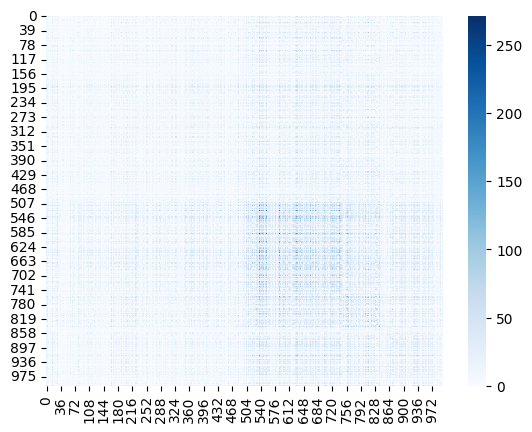

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

X_ND = data['X_ND']
_ = sns.heatmap(X_ND @ X_ND.T, cmap='Blues')

As you can see above, the block structure is very faint. We can instead use our model to get a clearer picture of the similarity between observations.

---
#### **4a):** Implement the affinity matrix. 

In this question, you will run your EM algorithm on the data with the provided hyperparameters. Once converged, you will then use the results to compute the following **affinity matrix** $A \in (0,1)^{n \times n}$, where an entry $A_{ij}$ contains the following posterior expectation:

$$
A_{ij} = \mathbb{E}\left[z_i = z_j \mid X, \widehat{\Theta}^{\textrm{MAP}}\right] = \sum_{k=1}^K p(z_i=k, z_j=k \mid X, \widehat{\Theta}^{\textrm{MAP}} )
$$


Before running EM, **implement `compute_affinity_matrix`**. 

In [ ]:
def compute_affinity_matrix(params_state, belief_state):
    """Compute the expectation of the similarity matrix given MAP estimates of parameters.

    Args:
        params_state (dict): Dictionary containing the MAP estimates of the parameters.
        belief_state (dict): Dictionary containing the posterior expectations of latent variables.

    NOTE: Both dictionaries are passed in by default, but you might not need everything in them.

    Returns:
        torch.Tensor: The computed similarity matrix A_NN of shape (n, n), where A_NN[i, j] represents
                      the posterior expectation that observations i and j belong to the same cluster.
    """
    # YOUR CODE HERE
    # A_NN = ...
    return A_NN

---
#### **4b):** Run EM on the data with the provided hyperparameters. 

- Run the cell below. 

- The output should display a **heatmap of $A$ and a plot of the ELBO over iteration**.

- **Note:** The `em` function contains an assert statement which will crash if the ELBO ever decreases. **Do not comment this out.** If your ELBO is decreasing, there is a problem with your implementation, and you should return to previous steps and fix the issues.

In [ ]:
# run EM
params_state, belief_state, elbo_vals = em(data, hyperparams, max_iter=100, tol=1e-7)

# compute affinity matrix
A_NN = compute_affinity_matrix(params_state, belief_state)

# plot the ELBO and the affinity matrix
plt.plot(elbo_vals[10:]); plt.show()
sns.heatmap(A_NN, cmap='Blues'); plt.show()

#### **4c):** Run EM with random restarts. 
- Run the cell below.

- This will run EM fifty times with random restarts. 

- Our implementation does this in under a minute. If yours is taking much longer, you should look at the bottlenecks in your code.

- The output should display 50 plots of the ELBO for the 50 random restarts.

In [ ]:
best_params_state = {}
best_belief_state = {}
best_elbo_vals = [-torch.inf]
n_random_restarts = 50
for _ in tqdm(range(n_random_restarts)):
    seed = torch.randint(0, 10000, (1,)).item()
    params_state, belief_state, elbo_vals = em(data, hyperparams, max_iter=100, tol=1e-8, seed=seed, verbose=False)
    plt.plot(elbo_vals[10:])
    if elbo_vals[-1] > best_elbo_vals[-1]:
        best_belief_state = belief_state
        best_params_state = params_state
        best_elbo_vals = elbo_vals

plt.show()

---
## **Question 5:** Matrix completion [Code, results]

In this final problem, you will use your estimate $\widehat{\Theta}^{\textrm{MAP}}$ to do matrix completion on a test matrix $Y$.

The test matrix $Y$ is $m \times D$ where the $m$ rows correspond to $i=n, n+1,\dots, n+m$ new observations.

**The first three columns of $Y$ are missing**. The full matrix is $Y = [Y^{\textrm{(obs)}}, Y^{\textrm{(miss)}}]$ where $Y^{\textrm{(obs)}}$ is $m \times (D-3)$ and $Y^{\textrm{(miss)}}$ is $m \times 3$.

You will only observe $Y^{\textrm{(obs)}}$. Your job is to use the MAP estimate of the parameters that you obtained in the previous problem (by fitting to $X$) to calculate the following posterior predictive expectation:

$$\mathbb{E}[Y^{\textrm{(miss)}} \mid Y^{\textrm{(obs)}}, X, \widehat{\Theta}^{\textrm{MAP}}]$$

- Your solution should not call `m_step` or any other function that updates the parameters.

- **Hint:** Your solution should make use of the `e_step` function you previously implemented. You do not need to change that function at all if you are clever about what input you pass to it.

- **Hint:** We have created for you `params_state_obs`, a dictionary that contains portions of $\widehat{\Theta}^{\textrm{MAP}}$ which may be useful.

- Your code should ultimately create a tensor called `EY_MD_miss`, which contains the predictions of $Y^{\textrm{(miss)}}$.

- After implementing your solution, run the cell so that it prints the RMSE on the missing portion of the test matrix and compares it to the RMSE of a naive estimator (which is based only on the empirical mean of $Y^{\textrm{(obs)}}$).

In [ ]:
with open('test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

Y_MD_obs = test_data['Y_MD_obs']

K = hyperparams['alpha_K'].shape[0]
m, D1 = Y_MD_obs.shape

params_state_obs = {'omega_KD': best_params_state['omega_KD'][:, 3:],
                    'lambd_KD': best_params_state['lambd_KD'][:, 3:],
                    'pi_K': best_params_state['pi_K']}

# YOUR CODE HERE
# EY_MD_miss = ...

rmse_model = torch.sqrt(torch.mean((EY_MD_miss - test_data['Y_MD_miss'])**2))
rmse_naive = torch.sqrt(torch.mean((Y_MD_obs.mean() - test_data['Y_MD_miss'])**2))

print(f'RMSE of model-based estimator: {rmse_model:.3f}')
print(f'RMSE of naive estimator: {rmse_naive:.3f}')